## Quantifying n-photon indistinguishability with a cyclic integrated interferometer

This notebook reproduces part of the results in https://arxiv.org/pdf/2201.13333.pdf.

Author: Mathias Pont (mathias.pont@c2n.upsaclay.fr)<br>
Affiliation:<br>
Centre for Nanosciences and Nanotechnology, CNRS, Universite Paris-Saclay, UMR 9001,<br>
10 Boulevard Thomas Gobert,<br>
91120 Palaiseau, France<br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
plt.rcParams['figure.figsize'] = (16,8)

In [2]:
import perceval as pcvl
token_qcloud = '<your token cloud>'

In [3]:
p_fringes = [
    [1, 3, 5, 7],
    [1, 2, 3, 6],
    [0, 3, 5, 6],
    [0, 2, 3, 7],
    [1, 4, 5, 6],
    [1, 2, 4, 7],
    [0, 4, 5, 7],
    [0, 2, 4, 6],
]

n_fringes = [
    [1, 3, 5, 6],
    [1, 2, 3, 7],
    [0, 3, 5, 7],
    [0, 2, 3, 6],
    [1, 4, 5, 7],
    [1, 2, 4, 6],
    [0, 4, 5, 6],
    [0, 2, 4, 7],
]

In [4]:
def postselect_outputstate(output_state):
    state_list = []
    for m in str(output_state):
        if m.isdigit():
            state_list.append(int(m))

    nb_of_result = 4 - state_list.count(0) + 1

    if nb_of_result < 1:
        return None

    s = []
    for ch, N in enumerate(state_list):
        if N > 0:
            s.append(ch)

    if nb_of_result > 1:
        r = []
        for group in list(combinations(s, r=4)):
            r.append(list(group))
        return r
    else:
        r = [s]
        return r

class Optical_circuit():
    # Construct 8-mode cyclic interferometer.
    def __init__(self):
        self.outcome = p_fringes + n_fringes

        self.circuit = pcvl.Circuit(m=8, name="4PhotonChip")

        for i in range(4):
            self.circuit.add((2 * i, 2 * i + 1), pcvl.BS())

        self.circuit.add(0, pcvl.PS(pcvl.Parameter('alpha')))

        for i in range(3):
            self.circuit.add((2 * i + 1, 2 * i + 2), pcvl.BS())
            self.circuit.add(2*i+1, pcvl.PS(phi=pcvl.P(f"phi{i}")))
            self.circuit.add((2 * i+1, 2 * i + 2), pcvl.BS())

        self.circuit.add((0, 1), pcvl.PERM([1, 0]))
        self.circuit.add((1, 2), pcvl.PERM([1, 0]))
        self.circuit.add((2, 3), pcvl.PERM([1, 0]))

        self.circuit.add((6, 7), pcvl.PERM([1, 0]))
        self.circuit.add((5, 6), pcvl.PERM([1, 0]))
        self.circuit.add((4, 5), pcvl.PERM([1, 0]))

        self.circuit.add((3, 4), pcvl.BS())
        self.circuit.add(3, pcvl.PS(phi=pcvl.P(f"phi{3}")))
        self.circuit.add((3, 4), pcvl.BS())


        self.phase_shifters = self.circuit.get_parameters()

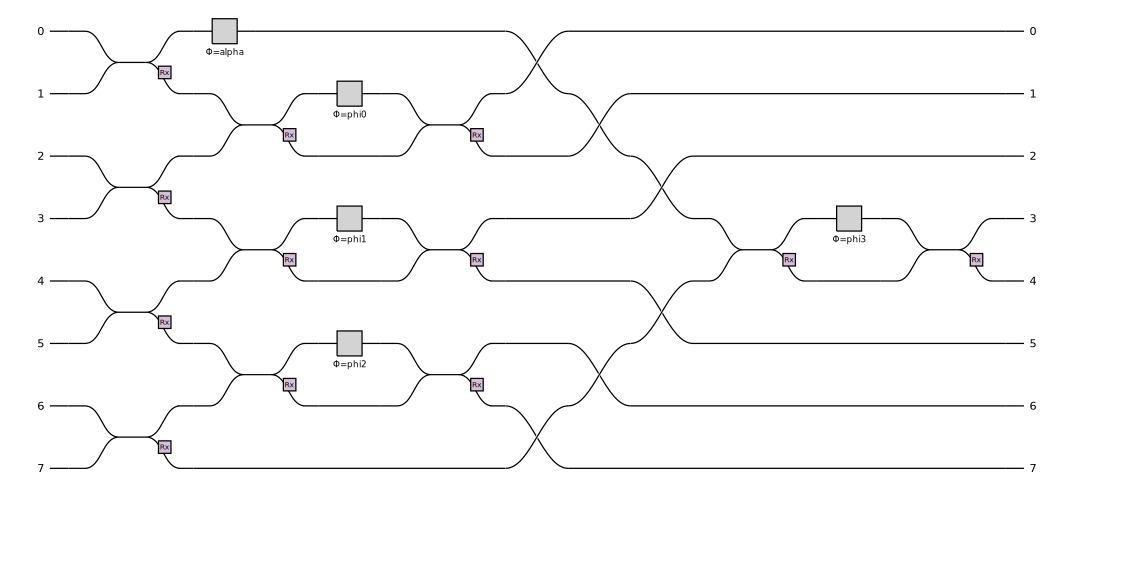

In [5]:
chip = Optical_circuit()
from perceval.rendering.circuit import SymbSkin, PhysSkin
pcvl.pdisplay(chip.circuit, skin=SymbSkin())

In [6]:
def compute_remote_async(qpu1, qpu2, nsamples, token_qcloud, phi, phibs=np.pi/2):

    chip = Optical_circuit()

    chip.phase_shifters[0].set_value(phi)

    for i in range(1,5):
        chip.phase_shifters[i].set_value(phibs)

    input_state = pcvl.BasicState([1, 0, 1, 0, 1, 0, 1, 0])
    circuit = chip.circuit

    # run the circuit on SIMULATOR first
    remote_qpu = pcvl.RemoteProcessor(qpu1, token_qcloud)

    remote_qpu.with_input(input_state)
    remote_qpu.set_circuit(circuit)

    # synchronous syntax
    sampler = pcvl.algorithm.Sampler(remote_qpu)
    job = sampler.sample_count(1000)

    compiled_circuit = job["computed_circuit"]
    compiled_input = job["computed_input"]

    # Used compiled results to run the circuit on the HARDWARE
    remote_qpu = pcvl.RemoteProcessor(qpu2, token_qcloud)

    remote_qpu.with_input(compiled_input)
    remote_qpu.set_circuit(compiled_circuit)
    remote_qpu.mode_post_selection(4)

    # synchronous syntax
    sampler = pcvl.algorithm.Sampler(remote_qpu)
    job = sampler.sample_count

    async_job = job.execute_async(nsamples)

    return async_job, job.id

In [7]:
def get_job_results(qpu, token_qcloud, job_id, phi):

    remote_processor = pcvl.RemoteProcessor(qpu, token_qcloud)
    job = remote_processor.resume_job(job_id)

    sv_out = job.get_results()["results"]

    empirical_table = {phi: {'p': 0, 'n': 0}}

    for output_state in sv_out:
        result = postselect_outputstate(output_state)
        if result:
            for r in result:
                if r in p_fringes:
                    empirical_table[phi]['p'] += sv_out[output_state]
                if r in n_fringes:
                    empirical_table[phi]['n'] += sv_out[output_state]

    norm_factor = empirical_table[phi]['n'] + empirical_table[phi]['p']

    empirical_table[phi]['p'] = empirical_table[phi]['p'] / norm_factor
    empirical_table[phi]['n'] = empirical_table[phi]['n'] / norm_factor

    return job, empirical_table

In [8]:
# qpu2 can be either "sim:ascella" or "qpu:ascella"
qpu1 = "sim:ascella"
qpu2 = "sim:ascella"

In [9]:
async_job_corr, job_id_corr = compute_remote_async(qpu1=qpu1,
                                                   qpu2=qpu2,
                                                   token_qcloud=token_qcloud,
                                                   nsamples=2000,
                                                   phi=np.pi,
                                                   phibs=np.pi/2)

HTTPError: 401 Client Error: UNAUTHORIZED for url: https://api.cloud.quandela.com/api/platform/sim%3Aascella

In [60]:
print(async_job_corr.is_complete)

True


In [61]:
job_corr, e_t = get_job_results(qpu2, token_qcloud, job_id_corr, np.pi)

print((e_t[np.pi]['p']-e_t[np.pi]['n'])/(e_t[np.pi]['p']+e_t[np.pi]['n']))
print(e_t)

-0.5996222851746931
{3.141592653589793: {'p': 0.7998111425873465, 'n': 0.20018885741265344}}


8
8
8
8


/var/folders/90/kj8chdqx4pjgntv02_t1hhk00000gn/T/ipykernel_20785/1898070784.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=20)


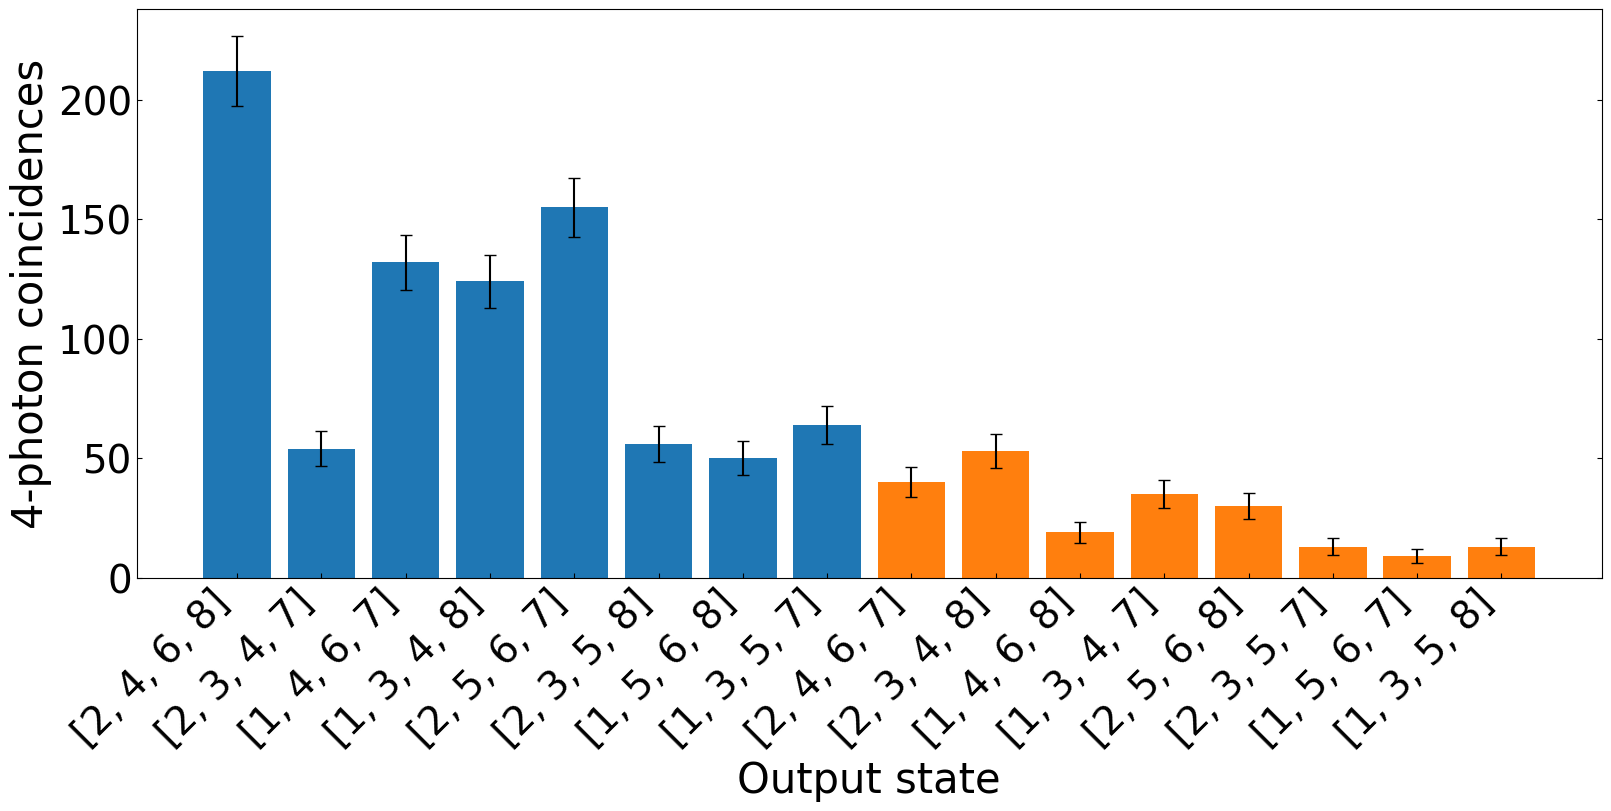

In [62]:
probability_distribution = job_corr.get_results()['results']

fig, ax = plt.subplots(constrained_layout=True)
histo_p={}
histo_n={}
groups_labels_p = [str([i+1 for i in g]) for g in p_fringes]
groups_labels_n = [str([i+1 for i in g]) for g in n_fringes]
for output_state in probability_distribution:
        result = postselect_outputstate(output_state)
        if result:
            for r in result:
                if r in p_fringes:
                    histo_p[output_state] = probability_distribution[output_state]
                if r in n_fringes:
                    histo_n[output_state] = probability_distribution[output_state]
histo_p_str = {str(k): histo_p[k] for k in histo_p}
histo_n_str = {str(k): histo_n[k] for k in histo_n}
print(len(groups_labels_p))
print(len(histo_p_str.values()))
ax.bar(histo_p_str.keys(), histo_p_str.values(), yerr=[np.sqrt(i) for i in histo_p_str.values()],
       capsize=4, label='Constructive outputs')
print(len(histo_n_str.keys()))
print(len(histo_n_str.values()))
ax.bar(histo_n_str.keys(), histo_n_str.values(), yerr=[np.sqrt(i) for i in histo_n_str.values()],
       capsize=4, label='Destructive outputs')
ax.set_xlabel('Output state', fontsize=30)
ax.set_ylabel('4-photon coincidences', fontsize=30)
xticklabels = groups_labels_p + groups_labels_n
ax.set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=20)
ax.tick_params(direction='in', bottom=True, top=False, left=True, right=True, labelsize = 28)